In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
// Code to be able to number equations in the markdown

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Explicit finite difference scheme

### Rewriting equation in terms of row (position) and column (time) indicies.

The equation (Eq. 4.0 in doc) given to me by Jack is: 

\begin{equation}
E^{n+1}_i = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 (E^{n}_{i+1} - 2E^{n}_{i} + E^{n}_{i-1})-(-2E^{n}_{i} + E^{n-1}_{i})
\end{equation}

where $ \displaystyle r = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 $ and n is the position index and i is the time index (dimensionless)

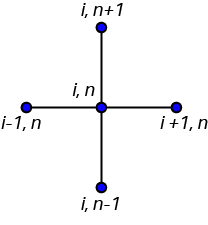

Using the image above, we use [i,n] ; [i-1,n] ; [i+1,n] ; [i, n-1] and take a weighted average to find [i,n+1].

### Defining global arrays for I, E, T_e, T_i, n_e, rho


In [3]:
I = np.zeros((10, 10))
E = np.zeros((10, 10))
T_e = np.zeros((10, 10))
T_i = np.zeros((10, 10))
n_e = np.zeros((10, 10))
rho = np.zeros((10, 10))

### Defining parameters needed to solve differential equation: $ \nabla^{2} E - \frac{n^2}{c^2} \frac{\partial^2 E}{\partial t^{2}} = 0$

In [6]:
# Unit conversions
ps = 10**-12    # picoseconds unit
nm = 10**-9     # nanometers unit
um = 10 ** -6   # micrometer unit
    
# Physical parameters
RefractiveIndex = 1                         # unitless
speed_of_light = 299792458                  # in m/s
wavelength = 351 * nm # we choose wavelength

# time-step size “dt” is strictly controlled by Courant–Friedrichs–Lewy (CFL) condition 
#so that the wave propagation distance within a allowed time-step size cannot exceed the grid size “dx”.
CFL = 0.1
delta_x = 0.001 * wavelength
delta_t = CFL * delta_x / speed_of_light    # time related time-step

# Physics formulas
frequency = speed_of_light/wavelength       # in Hertz
angular_frequency = 2 * np.pi * frequency   # in Hertz
wavenumber = (2 * np.pi) / wavelength       # wave number 'k' will be imaginary part in the coming days (when we do it correctly)
period = wavelength / speed_of_light        # wave period (can also be calculated with 1/f)

# Grid and time parameters
lambda_mult = 10  # cont
# T = 1 * ps              # time in seconds (* picoseonds) (in the future, will represent modeling time)
T = lambda_mult * period
n_timestep = int(T/delta_t)        # n time step
n_cycles = period / delta_t  # number of timesteps to finish one period
ntimestep_dividedby_ncycle = n_timestep / n_cycles # equal to number of periods passing through simulation time 
# L = 500 * nm            # length in SI units in meters

L = wavelength * lambda_mult
n_cells = int(L/delta_x)            # number of cells (can also think of as number of grid points)
# delta_x = L/n_cells     # spatial time-step (can also think of as grid spacing)

### Initializing laser intensity and electric field

In [7]:
R = 25 * um # radius of laser
E_L = 10 * (10 ** -6) # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2 # area of laser
T_laser = 100 * ps # laser pulse time
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12

# Electric field
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * RefractiveIndex * permittivity_free_space) ) # SI unit is voltage / m

# Laser intensity
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )

### Solving explicitly using Eq (1): $E^{n+1}_i = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 (E^{n}_{i+1} - 2E^{n}_{i} + E^{n}_{i-1})-(-2E^{n}_{i} + E^{n-1}_{i})$

In [8]:
x = []  # spatial domain (can also think of as coordinates of grid points)
t = []  # time domain

# Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
# The ghost cells are there so that in the matrix we can access all indeces
# To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
for i in range(-2, n_cells + 3):
    x.append(delta_x * (i + 0.5))

for i in range(-2, n_timestep + 3):
    t.append(delta_t * (i + 0.5))
    
x = np.array(x)
t = np.array(t)

# BEFORE: E = np.zeros((len(x), len(t)))
E = np.zeros((len(t), len(x)))
# E_10 = np.zeros((len(t), len(x)))

r_const = ( (delta_t/delta_x) * (speed_of_light/RefractiveIndex) ) ** 2 # our parameter
print('r_const', r_const)

# These loops will go through the grid. We start at 1 so as to not calculate the
# value when the a time or spatial point is equal to 0.
index = 0
for n in range(1, (len(t) - 3)*0 + 3):
    t_sim = t[n] # in seconds
    
    # Initial conditions in time:
    E[n-1, 0] = E_0 * np.sin( angular_frequency * t[n-1] - wavenumber * x[0] )
    E[n-1, 1] = E_0 * np.sin( angular_frequency * t[n-1] - wavenumber * x[1] )
    
    # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
    E[n, 0] = E_0 * np.sin( angular_frequency * t[n] - wavenumber * x[0] )
    E[n, 1] = E_0 * np.sin( angular_frequency * t[n] - wavenumber * x[1] )
    
    # We have no laser on the left, so boundary conditions are just 0
    E[n, -1] = 0
    E[n, -2] = 0
    
    # Initial conditions in time:
    E[1, 2:] = 0
    for i in range(2, len(x) - 3):
        E[n+1, i] = (r_const) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) - ( -2*E[n, i] + E[n-1, i] )
        
#         print('E[n+1, i]/E_0', E[n+1, i]/E_0)
        if n == 2:
            print('index', index, 'n+1', n+1, 'i', i, 'E[n+1, i]', E[n+1, i], 'E[n+1, i]/E_0', E[n+1, i]/E_0, (r_const) * (E[n, i+1] - 2*E[n, i] + E[n, i-1]), -2*E[n, i] + E[n-1, i], E[n, i-1] * r_const)
        
        # if the ratio is not bounded to from -1 to 1, then we have overshot and are out of simulation physical bounds
        if (True) and abs(E[n+1, i]/E_0) > 1:
            print('stop')
            #print('index', index, 'n+1', n+1, 'i', i, "E[n+1, i] {:.{}e}".format(E_complex[n+1, i], precision_num), 'abs(E[n+1, i])/abs(E_0) {:.{}e}'.format(abs(E_complex[n+1, i])/abs(E_0), precision_num))
            print('index', index, 'n+1', n+1, 'i', i, 'E[n+1, i]', E[n+1, i], 'E[n+1, i]/E_0', E[n+1, i]/E_0, (r_const) * (E[n, i+1] - 2*E[n, i] + E[n, i-1]), -2*E[n, i] + E[n-1, i], E[n, i-1] * r_const)
            break
    
        index += 1

r_const 0.010000000000000004
index 999 n+1 3 i 2 E[n+1, i] 17736.115066370556 E[n+1, i]/E_0 9.054055690247185e-05 6658.732992478301 -11077.382073892255 6769.506813217224
index 1000 n+1 3 i 3 E[n+1, i] 55.3869103694613 E[n+1, i]/E_0 2.8274296209697056e-07 55.3869103694613 0.0 55.3869103694613
index 1001 n+1 3 i 4 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1002 n+1 3 i 5 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1003 n+1 3 i 6 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1004 n+1 3 i 7 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1005 n+1 3 i 8 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1006 n+1 3 i 9 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1007 n+1 3 i 10 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1008 n+1 3 i 11 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1009 n+1 3 i 12 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1010 n+1 3 i 13 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0 0.0 0.0 0.0
index 1011 n+1 3 i 14 E[n+1, i] 0.0 E[n+1, i]/E_0 0.0

In [9]:
plt.plot(x/nm, E[19999, :])

IndexError: index 19999 is out of bounds for axis 0 with size 10004

In [ ]:
E.shape

In [ ]:
n_timestep

In [ ]:
plt.plot(x/nm, E[9999 * 10, :], 'ro')

In [ ]:
plt.plot(x/nm, E[9999 * int(9.5), :], 'ro')

In [ ]:
plt.plot(E_0 * np.sin( angular_frequency * t - wavenumber * x[0] ))

In [ ]:
delta_t

In [ ]:
T/delta_t

In [ ]:
(delta_t * 600) / period

## Modeling the damping wave

In [144]:
# defining complex index of refraction
n_r = 1
# n_i = 6.48
n_i = 0.5
# complex_refractive_index = np.cdouble(complex(n_r, n_i))
complex_refractive_index = complex(n_r, n_i)
complex_wavenumber = (angular_frequency / speed_of_light) * complex_refractive_index

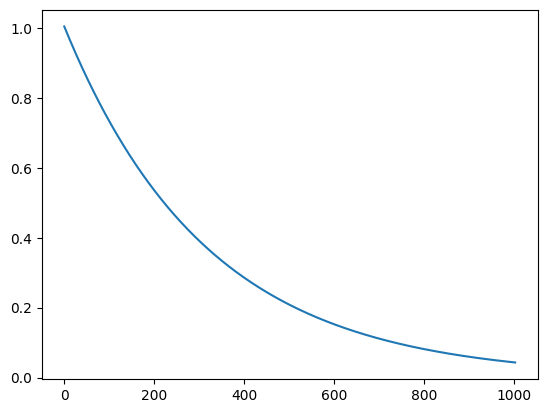

In [145]:
plt.plot(np.exp(-complex_wavenumber.imag * x))

In [115]:
wavenumber

17900812.84096748

In [116]:
complex_wavenumber

(17900812.84096748+0j)

In [117]:
complex_wavenumber * 1j

17900812.84096748j

In [118]:
(1/complex_wavenumber.imag) / nm

ZeroDivisionError: float division by zero

In [119]:
R = 25 * um # radius of laser
E_L = 10 * (10 ** -6) # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2 # area of laser
T_laser = 100 * ps # laser pulse time
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12

# Electric field (same as before but now using complex refractive index)
refract_index_ghost = 1
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * refract_index_ghost * permittivity_free_space)) # SI unit is voltage / m

# Laser intensity
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )

In [120]:
E_0

195891384.73574314

In [121]:
wavenumber

17900812.84096748

In [122]:
E_complex = 1j * np.zeros((len(t), len(x)))

In [123]:
from time import process_time

In [124]:
r_const_complex.real

0.009997000499930011

In [125]:
np.exp(-complex_wavenumber.imag * x[2])

1.0

In [126]:
# Start the stopwatch / counter 
t1_start = process_time() 

x = []  # spatial domain (can also think of as coordinates of grid points)
t = []  # time domain

# Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
# The ghost cells are there so that in the matrix we can access all indeces
# To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
for i in range(-2, n_cells + 3):
    x.append(delta_x * (i + 0.5))

for i in range(-2, n_timestep + 3):
    t.append(delta_t * (i + 0.5))
    
x = np.array(x)
t = np.array(t)

E_complex = 1j * np.zeros((len(t), len(x)))

print('E_complex.max()', E_complex.max()) 
print('E_complex.min()', E_complex.min())

r_const_complex = ( (delta_t/delta_x) * (speed_of_light/complex_refractive_index) ) ** 2 # our parameter
print('r_const_complex', r_const_complex)

# These loops will go through the grid. We start at 1 so as to not calculate the
# value when the a time or spatial point is equal to 0.
index = 0
for n in range(1, (len(t) - 3)*1 + 0):
    t_sim = t[n] # in seconds
    
    # Defning cos and sin terms for wave to later be turned into complex numbers for t_nm1
    cos_term_0_t_nm1 = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n-1]) + np.pi/2)
#     sin_term_0_t_nm1 = E_0 * np.sin((wavenumber * x[0]) - (angular_frequency * t[n-1]) + np.pi/2)
    sin_term_0_t_nm1 = 0
    
    cos_term_1_t_nm1 = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n-1]) + np.pi/2)
#     sin_term_1_t_nm1 = E_0 * np.sin((wavenumber * x[1]) - (angular_frequency * t[n-1]) + np.pi/2)
    sin_term_1_t_nm1 = 0
    
#     print('cos_term_0_t_nm1', cos_term_0_t_nm1)
#     print('sin_term_0_t_nm1', sin_term_0_t_nm1)
#     print('cos_term_1_t_nm1', cos_term_1_t_nm1)
#     print('sin_term_1_t_nm1', sin_term_1_t_nm1)

    
    # Initial conditions in time:
    E_complex[n-1, 0] = complex(cos_term_0_t_nm1, sin_term_0_t_nm1)
    E_complex[n-1, 1] = complex(cos_term_1_t_nm1, sin_term_1_t_nm1)
    
#     print('E_complex[n-1, 0]', E_complex[n-1, 0])
#     print('E_complex[n-1, 1]', E_complex[n-1, 1])
#     print('abs(E_complex[n-1, 0])', abs(E_complex[n-1, 0]), 'abs(E_complex[n-1, 1])', abs(E_complex[n-1, 1]))
#     print('E_0', E_0)

    
    # Defning cos and sin terms for wave to later be turned into complex numbers for t_n
    cos_term_0_t_n = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n]) + np.pi/2)
#     sin_term_0_t_n = E_0 * np.sin((wavenumber * x[0]) - (angular_frequency * t[n]) + np.pi/2)
    sin_term_0_t_n = 0
    
    cos_term_1_t_n = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n]) + np.pi/2)
#     sin_term_1_t_n = E_0 * np.sin((wavenumber * x[1]) - (angular_frequency * t[n]) + np.pi/2)
    sin_term_1_t_n = 0
    
#     print('cos_term_0_t_n', cos_term_0_t_n)
#     print('sin_term_1_t_n', sin_term_1_t_n)
    
    
    # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
    E_complex[n, 0] = complex(cos_term_0_t_n, sin_term_0_t_n)
    E_complex[n, 1] = complex(cos_term_1_t_n, sin_term_1_t_n)
    
#     print()
#     print('E_complex[n, 0]', E_complex[n, 0])
#     print('E_complex[n, 1]', E_complex[n, 1])
#     print('abs(E_complex[n, 0])', abs(E_complex[n, 0]), 'abs(E_complex[n, 1])', abs(E_complex[n, 1]))
#     print('E_0', E_0)
    
    # We have no laser on the left, so boundary conditions are just 0
    E_complex[n, -1] = complex(0)
    E_complex[n, -2] = complex(0)
    
    # Initial conditions in time:
#     E_complex[1, 2:] = 0
    
    precision_num = 10
    for i in range(2, len(x) - 3):
        
        E_complex[n+1, i] = np.exp(-complex_wavenumber.imag * x[i]) * ( (r_const_complex.real) * ( E_complex[n, i+1] - 2*E_complex[n, i] + E_complex[n, i-1] ) - ( -2*E_complex[n, i] + E_complex[n-1, i] ) )
        
        #constrain
        if (True) and abs(E_complex[n+1, i])/abs(E_0) > 1:
            E_complex[n+1, i] = E_0 * np.sign(E_complex[n, i])
            
            

#         E_complex[n+1, i] = E_complex[n+1, i] * np.exp(-complex_wavenumber.imag * x[i])

        if (False) and n == 2:
            print('index', index, 'n+1', n+1, 'i', i, "E[n+1, i] {:.{}e}".format(E_complex[n+1, i], precision_num), 'abs(E[n+1, i])/abs(E_0) {:.{}e}'.format(abs(E_complex[n+1, i])/abs(E_0), precision_num))
            

        # if the ratio is not bounded to from -1 to 1, then we have overshot and are out of simulation physical bounds
        if (False) and abs(E_complex[n+1, i])/abs(E_0) > 1:
            print('stop')
#             print('index', index, 'n+1', n+1, 'i', i, "E[n+1, i] {:.{}e}".format(E_complex[n+1, i], precision_num), 'abs(E[n+1, i])/abs(E_0) {:.{}e}'.format(abs(E_complex[n+1, i])/abs(E_0), precision_num))
            print('index', index, 'n+1', n+1, 'i', i, "E[n+1, i]", E_complex[n+1, i], 'abs(E[n+1, i])/abs(E_0) ', abs(E_complex[n+1, i])/abs(E_0))
            print()
            print("E_0 {:.{}e}".format(E_0, precision_num))
            print()
            print('(r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) {:.{}e}'.format((r_const_complex) * ( E_complex[n, i+1] - 2*E_complex[n, i] + E_complex[n, i-1] ), precision_num))
            print('abs((r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] )) {:.{}e}'.format(abs((r_const_complex) * ( E_complex[n, i+1] - 2*E_complex[n, i] + E_complex[n, i-1] )), precision_num))
            print()
            print('( -2*E[n, i] + E[n-1, i] ) {:.{}e}'.format( ( -2*E_complex[n, i] + E_complex[n-1, i] ), precision_num) )
            
            print('abs( -2*E[n, i] + E[n-1, i] ) {:.{}e}'.format( abs(( -2*E_complex[n, i] + E_complex[n-1, i] )), precision_num) )
            print()
            print('abs(r_const_complex) {:.{}e}'.format( abs(r_const_complex), precision_num) )
            print()
            
            print('E[n, i+1] {:.{}e}'.format(E_complex[n, i+1], precision_num), 'E[n, i] {:.{}e}'.format(E_complex[n, i], precision_num), 'E[n, i-1] {:.{}e}'.format(E_complex[n, i-1], precision_num), 'E[n-1, i] {:.{}e}'.format( E_complex[n-1, i], precision_num))
            print()
            print(abs(E_complex[n, i+1]/E_0),  abs(E_complex[n, i]/E_0), abs(E_complex[n, i-1]/E_0), abs(E_complex[n-1, i]/E_0))
            print()
            
            print('cos_term_0_t_nm1', cos_term_0_t_nm1)
            print('sin_term_0_t_nm1', sin_term_0_t_nm1)
            print('cos_term_1_t_nm1', cos_term_1_t_nm1)
            print('sin_term_1_t_nm1', sin_term_1_t_nm1)
            
            print(np.sqrt(cos_term_0_t_nm1 ** 2 + sin_term_0_t_nm1 ** 2))
            print(np.sqrt(cos_term_1_t_nm1 ** 2 + sin_term_1_t_nm1 ** 2))
            
            print(np.sqrt(cos_term_0_t_n ** 2 + sin_term_0_t_n ** 2))
            print(np.sqrt(cos_term_1_t_n ** 2 + sin_term_1_t_n ** 2))
            print()
            break
    
        index += 1
        
# Stop the stopwatch / counter
t1_stop = process_time()
   
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in minutes:",
                                         t1_stop/60 -t1_start/60 ) 

E_complex.max() 0j
E_complex.min() 0j
r_const_complex (0.010000000000000004+0j)
Elapsed time: 168.09375 139.03125
Elapsed time during the whole program in minutes: 0.484375


In [127]:
(82 * delta_t )/T

0.008200000000000002

In [128]:
E_complex.shape

(10004, 1004)

In [143]:
-complex_wavenumber.imag

-1790081.284096748

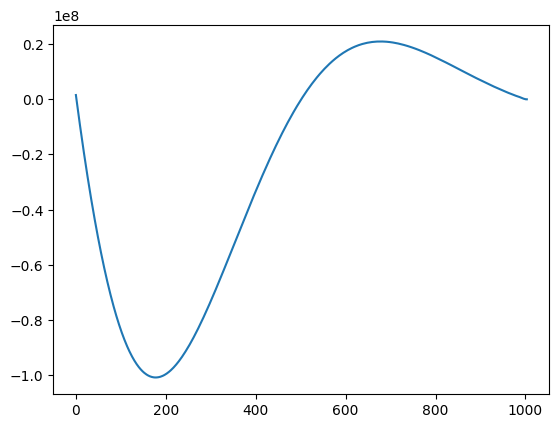

In [146]:
plt.plot(np.exp(-complex_wavenumber.imag * x) * E_complex[int(9999 * 1), :].real)

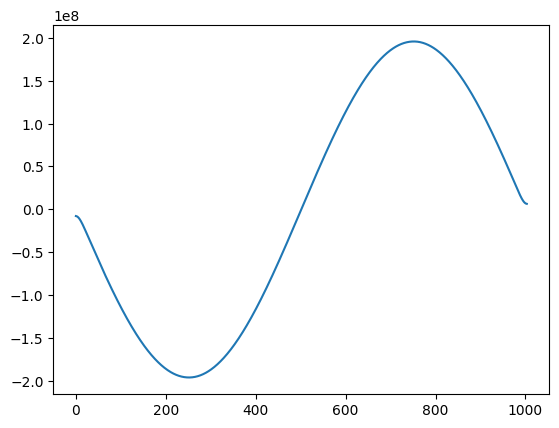

In [130]:
plt.plot(gaussian_filter1d(E_complex[int(9999 * 1), :], 10))

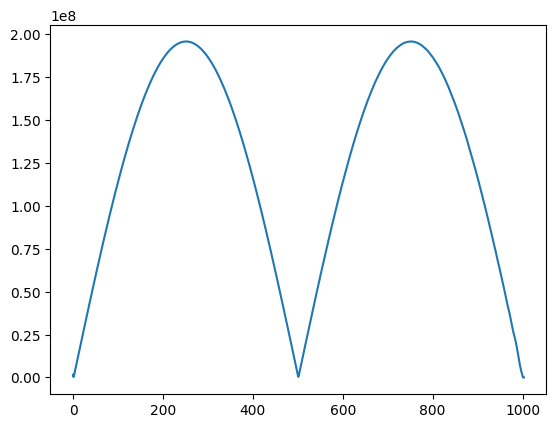

In [131]:
plt.plot(abs(E_complex[int(9999 * 1), :]))

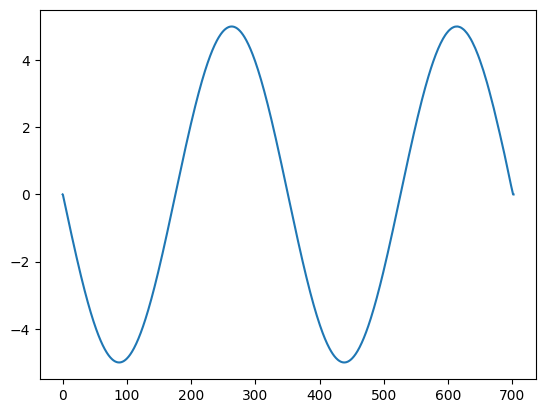

In [132]:
plt.plot(x/nm, E_complex[9999 * 10, :]/E_0)

In [13]:
cos_term_0_t_nm1 = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t) + np.pi/2)
sin_term_0_t_nm1 = E_0 * np.sin((wavenumber * x[0]) - (angular_frequency * t) + np.pi/2)

cos_term_1_t_nm1 = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t) + np.pi/2)
sin_term_1_t_nm1 = E_0 * np.sin((wavenumber * x[1]) - (angular_frequency * t) + np.pi/2)

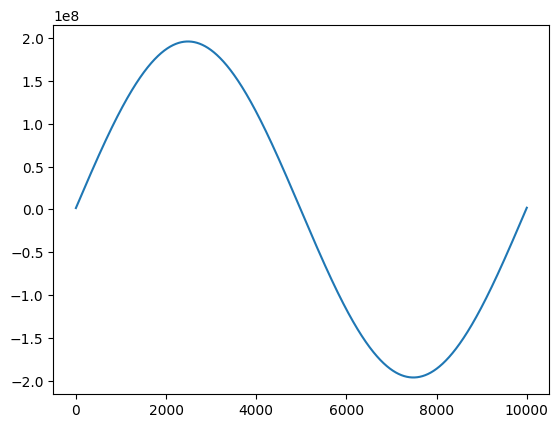

In [14]:
plt.plot(E_0 * np.sin( angular_frequency * t - wavenumber * x[0] ))

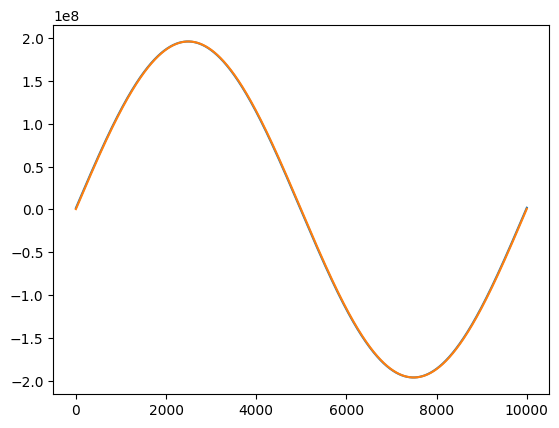

In [15]:
plt.plot(cos_term_0_t_nm1)
plt.plot(cos_term_1_t_nm1)
plt.show()

C:\Users\nickd\OneDrive\Documents\GitHub\PFURO-2023-PRIV\Code\pfurovenv\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


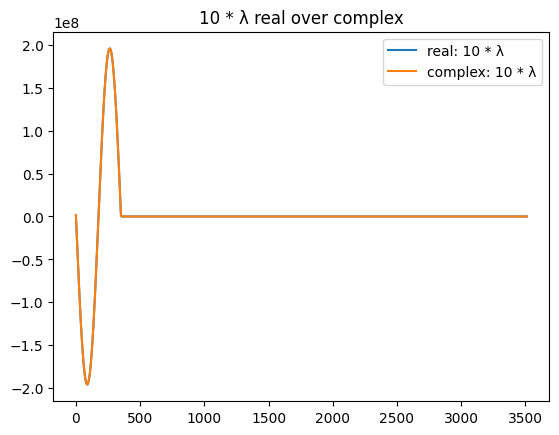

In [13]:
plt.plot(x/nm, E[9999, :])
plt.plot(x/nm, E_complex[9999, :])
format_title = "{} * λ real over complex".format(lambda_mult)
plt.title(format_title)
plt.legend(["real: {} * λ".format(lambda_mult), "complex: {} * λ".format(lambda_mult)])
plt.savefig('{}_times_lambda.png'.format(lambda_mult))

In [68]:
cos_term_0_t_n = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t))
sin_term_0_t_n = E_0 * np.sin((wavenumber * x[0]) - (angular_frequency * t))

cos_term_1_t_n = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t))
sin_term_1_t_n = E_0 * np.sin((wavenumber * x[1]) - (angular_frequency * t))

In [254]:
cos_term_0_t_nm1

923112.9862372458

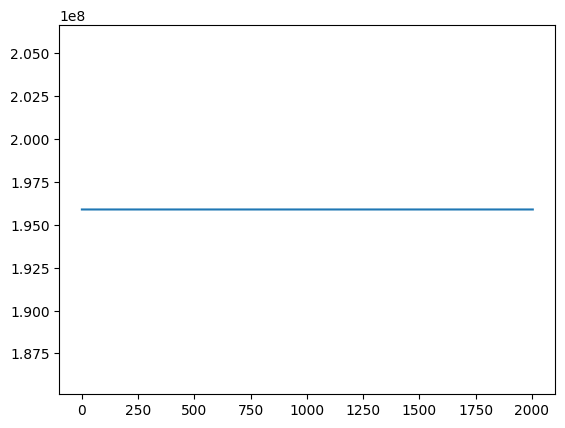

In [244]:
plt.plot(np.sqrt(cos_term_1_t_nm1 ** 2 + sin_term_1_t_nm1 ** 2))

In [29]:
from scipy.ndimage import gaussian_filter1d

In [ ]:
plt.plot(x/nm, gaussian_filter1d(E[2000, :].real, 5))

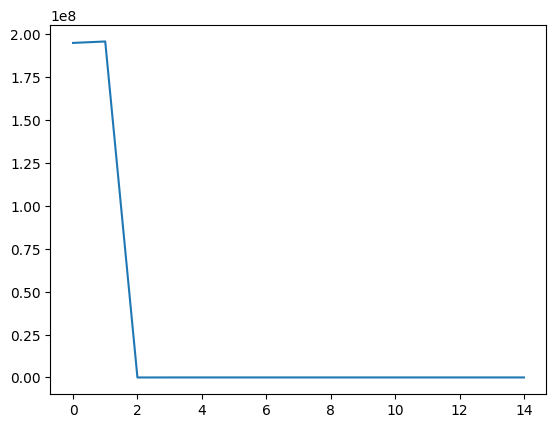

In [92]:
plt.plot(E[10,:])

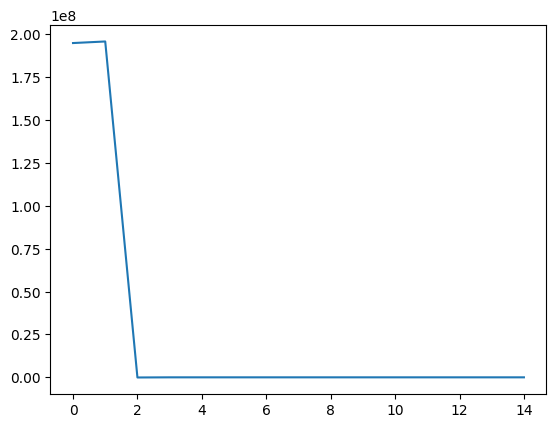

In [93]:
plt.plot(E[20, :])

In [ ]:
plt.plot()

In [85]:
(delta_t * 820) / period 

0.082

In [42]:
r_const_complex = ( (delta_t/delta_x) * (speed_of_light/complex_refractive_index) ) ** 2

In [43]:
r_const_complex

(-0.00022620085993920567-6.0381765805633185e-05j)

In [38]:
complex(cos_term_0_t_nm1, sin_term_0_t_nm1)

(76350402.8111051-6491847.304042041j)

In [26]:
E_complex.shape

(10004, 1004)

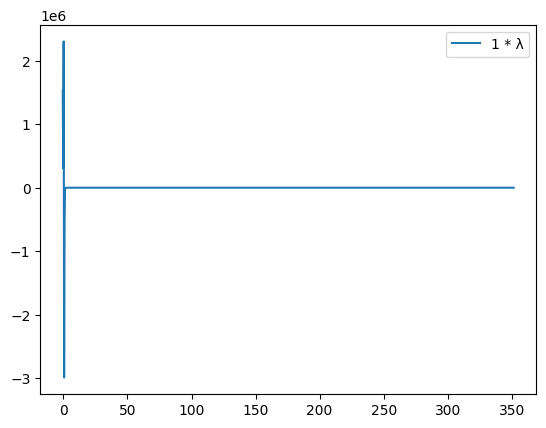

## Laser source

Plot an animated wave through time.

In [ ]:
plt.plot(E)
plt.legend
plt.show()

In [ ]:
%matplotlib notebook

In [ ]:
Y_UPPER_LIMIT = 3 * 10**8
Y_LOWER_LIMIT = -3 * 10**8

In [ ]:
fig, ax = plt.subplots()
ax.set(xlim=(0, 100), ylim=(Y_LOWER_LIMIT, Y_UPPER_LIMIT))

line = ax.plot(x, E[:,0], color='k', lw=2)[0]

def animate(i):
    line.set_ydata(E[:,i])
    
anim = FuncAnimation(fig, animate, interval=1, frames=100)
 
anim.save('filename.gif')
    
# plt.draw()
plt.show()

In [ ]:
# initializing a figure in 
# which the graph will be plotted
fig = plt.figure() 
   
# marking the x-axis and y-axis
axis = plt.axes(xlim=(0, 100), ylim=(Y_LOWER_LIMIT, Y_UPPER_LIMIT)) 
  
# initializing a line variable
line, = axis.plot([], [], lw = 3) 

# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([])
    return line,
   
def animate(i):
#     x = np.linspace(0, 4, 1000)
   
    # plots a sine graph
#     y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(E[i])
      
    return line,
   
anim = FuncAnimation(fig, animate, init_func = init,
                     frames = 1, interval = 20, blit = True)
  
anim.save('test.gif')

plt.show()